In [1]:
#import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
## Step 1: Perform Camera Calibration

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('../calib/Calibration*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        img_corners = cv2.drawChessboardCorners(img, (9,6), corners2, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
def undistort(distorted_img):
    return cv2.undistort(distorted_img, mtx, dist, None, mtx)




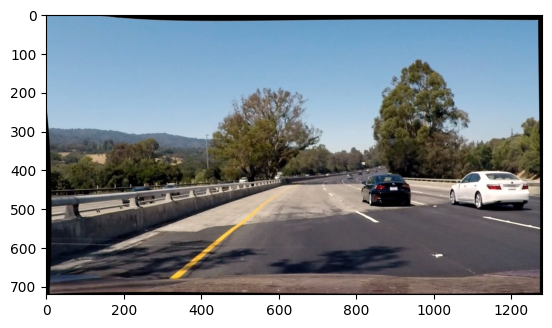

In [15]:
'''test'''
# img = mpimg.imread('../test_images/straight_lines1.jpg')
# img = cv2.imread('../test_images/straight_lines2.jpg')
# img = mpimg.imread('../test_images/test1.jpg')
#img = mpimg.imread('../test_images/test2.jpg')
# img = mpimg.imread('../test_images/test3.jpg')

img = mpimg.imread('../test_images/test4.jpg')
# img = mpimg.imread('../test_images/test5.jpg')
#img = mpimg.imread('../test_images/test6.jpg')

out_img = undistort(img)
plt.imshow(out_img)

In [18]:
## Step 2: Perspective Transform
def warped_birdview(img):
    undist = undistort(img)
    img_size = (img.shape[1], img.shape[0])
    offset = 300
    
    # Source points taken from images with straight lane lines, these are to become parallel after the warp transform
    src = np.float32([
        (215, 680), # bottom-left corner
        (600, 455), # top-left corner
        (685, 447), # top-right corner
        (1125, 720) # bottom-right corner
    ])
    # Destination points are to be parallel, taken into account the image size
    dst = np.float32([
        [offset, img_size[1]],             # bottom-left corner
        [offset, 0],                       # top-left corner
        [img_size[0]-offset, 0],           # top-right corner
        [img_size[0]-offset, img_size[1]]  # bottom-right corner
    ])
    # Calculate the transformation matrix and it's inverse transformation
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)
   
    return warped, M_inv


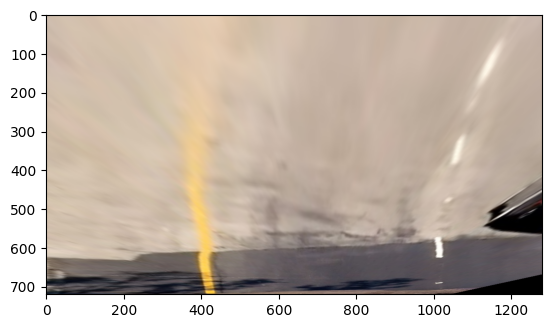

In [19]:
'''test'''
img = mpimg.imread('../test_images/straight_lines1.jpg')
# img = cv2.imread('../test_images/straight_lines2.jpg')
# img = mpimg.imread('../test_images/test1.jpg')
#img = mpimg.imread('../test_images/test2.jpg')
# img = mpimg.imread('../test_images/test3.jpg')

img = mpimg.imread('../test_images/test4.jpg')
# img = mpimg.imread('../test_images/test5.jpg')
#img = mpimg.imread('../test_images/test6.jpg')

warped, M_inv = warped_birdview(img)
plt.imshow(warped)

In [20]:
## STEP 3: Perform Binary Threshodling for Input
def binary_threshold(img):
    # Transform image to gray scale
    gray_img =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply sobel (derivative) in x direction, this is usefull to detect lines that tend to be vertical
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    # Scale result to 0-255
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sx_binary = np.zeros_like(scaled_sobel)
    # Keep only derivative values that are in the margin of interest
    sx_binary[(scaled_sobel >= 30) & (scaled_sobel <= 255)] = 1

    # # Detect pixels that are white in the grayscale image
    white_binary = np.zeros_like(gray_img)
    white_binary[(gray_img > 200) & (gray_img <= 255)] = 1

    # # Convert image to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    S = hls[:,:,2]
    sat_binary = np.zeros_like(S)
    # # Detect pixels that have a high saturation value
    sat_binary[(S > 90) & (S <= 255)] = 1

    hue_binary =  np.zeros_like(H)
    # # Detect pixels that are yellow using the hue component
    hue_binary[(H > 10) & (H <= 25)] = 1

    # # Combine all pixels detected above
    binary_1 = cv2.bitwise_or(sx_binary, white_binary)
    binary_2 = cv2.bitwise_or(hue_binary, sat_binary)
    binary = cv2.bitwise_or(binary_1, binary_2)
    
    return binary



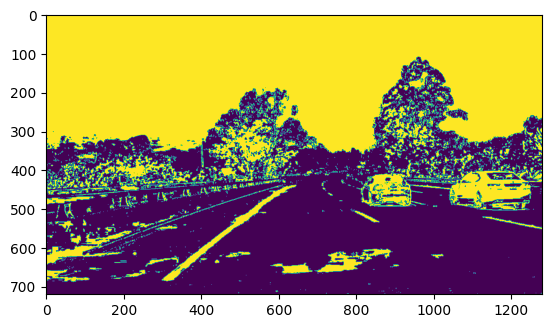

In [21]:
'''test'''
# img = mpimg.imread('../test_images/straight_lines1.jpg')
# img = cv2.imread('../test_images/straight_lines2.jpg')
# img = mpimg.imread('../test_images/test1.jpg')
#img = mpimg.imread('../test_images/test2.jpg')
# img = mpimg.imread('../test_images/test3.jpg')

img = mpimg.imread('../test_images/test4.jpg')
# img = mpimg.imread('../test_images/test5.jpg')
#img = mpimg.imread('../test_images/test6.jpg')

out_img = binary_threshold(img)
plt.imshow(out_img)

In [22]:
## STEP 4 Finding lane lines using Histogram and sliding windows
def sliding_window(binary_warped):
    # Take hítogram at the bottom half of warped img
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak at left and right halves
    midpoint = np.int(histogram.shape[0]//2)
    # quarterpoint = midpoint//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose number of sliding windows
    nwindows = 9
    # +/- margins
    margin = 100
    # minimum number of pixrls found to recenter windows
    minpix = 50

    # Set window height
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # identify x and y positions of non-zero pixels in the img
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #update current position
    leftx_current = leftx_base
    rightx_current = rightx_base

    #create empty list to receive left and right lane pixels indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
         # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def fit_poly(binary_warped, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def draw_poly_lines(binary_warped, left_fitx, right_fitx, ploty):     
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
        
    margin = 100
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (100, 100, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (100, 100, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='green')
    plt.plot(right_fitx, ploty, color='blue')
    ## End visualization steps ##
    return result




In [23]:
# img = mpimg.imread('../test_images/straight_lines1.jpg')
# img = cv2.imread('../test_images/straight_lines2.jpg')
# img = mpimg.imread('../test_images/test1.jpg')
#img = mpimg.imread('../test_images/test2.jpg')
# img = mpimg.imread('../test_images/test3.jpg')

img = mpimg.imread('../test_images/test4.jpg')
# img = mpimg.imread('../test_images/test5.jpg')
#img = mpimg.imread('../test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped, M_inv = warped_birdview(img)
binary_warped = binary_threshold(warped)

leftx, lefty, rightx, righty = sliding_window(binary_warped)

left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty )

In [24]:

left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
# plt.imshow(leftx)

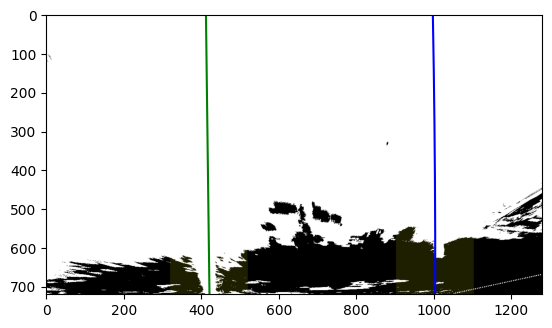

In [25]:
out_img = draw_poly_lines(binary_warped, left_fitx, right_fitx, ploty)
plt.imshow(out_img)

In [6]:
def find_lane_pixels_using_prev_poly(binary_warped):
    global prev_left_fit
    global prev_right_fit
    # width of the margin around the previous polynomial to search
    margin = 100
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                    prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + 
                    prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))).nonzero()[0]
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                    prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + 
                    prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin))).nonzero()[0]
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


In [26]:
def project_lane_info(img, binary_warped, ploty, left_fitx, right_fitx, M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0]))
    
    # Combine the result with the original image
    out_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    
    
    return out_img

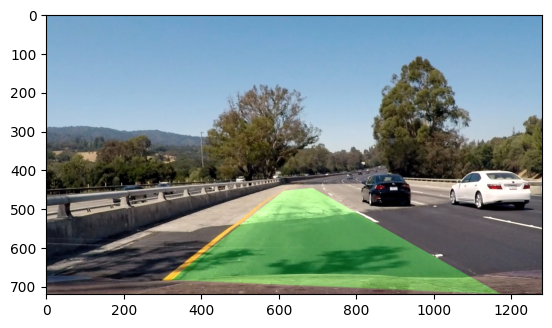

In [27]:
'''test'''
# img = mpimg.imread('../test_images/straight_lines1.jpg')
# img = cv2.imread('../test_images/straight_lines2.jpg')
# img = mpimg.imread('../test_images/test1.jpg')
#img = mpimg.imread('../test_images/test2.jpg')
# img = mpimg.imread('../test_images/test3.jpg')

img = mpimg.imread('../test_images/test4.jpg')
# img = mpimg.imread('../test_images/test5.jpg')
#img = mpimg.imread('../test_images/test6.jpg')

out_img = project_lane_info(img, binary_warped, ploty, left_fitx, right_fitx, M_inv)
plt.imshow(out_img)

In [28]:
global left_fit_hist 
left_fit_hist = np.array([])
#print(len(left_fit_hist))

global right_fit_hist 
right_fit_hist = np.array([])
def lane_finding_pipeline(img):
    global left_fit_hist 
    global right_fit_hist
    global prev_left_fit
    global prev_right_fit
    binary_thresh = binary_threshold(img)
    binary_warped, M_inv = warped_birdview(binary_thresh)
    #out_img = np.dstack((binary_thresh, binary_thresh, binary_thresh))*255
    if (len(left_fit_hist) == 0):
        leftx, lefty, rightx, righty = sliding_window(binary_warped)
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
        # Store fit in history
        left_fit_hist = np.array(left_fit)
        new_left_fit = np.array(left_fit)
        left_fit_hist = np.vstack([left_fit_hist, new_left_fit])
        right_fit_hist = np.array(right_fit)
        new_right_fit = np.array(right_fit)
        right_fit_hist = np.vstack([right_fit_hist, new_right_fit])
    else:
        prev_left_fit = [np.mean(left_fit_hist[:,0]), np.mean(left_fit_hist[:,1]), np.mean(left_fit_hist[:,2])]
        prev_right_fit = [np.mean(right_fit_hist[:,0]), np.mean(right_fit_hist[:,1]), np.mean(right_fit_hist[:,2])]
        leftx, lefty, rightx, righty = find_lane_pixels_using_prev_poly(binary_warped)
        if (len(lefty) == 0 or len(righty) == 0):
            leftx, lefty, rightx, righty = sliding_window(binary_warped)
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped,leftx, lefty, rightx, righty)
        
    #     # Add new values to history
        new_left_fit = np.array(left_fit)
        left_fit_hist = np.vstack([left_fit_hist, new_left_fit])
        new_right_fit = np.array(right_fit)
        right_fit_hist = np.vstack([right_fit_hist, new_right_fit])
        
    #     # Remove old values from history
        if (len(left_fit_hist) > 10):
            left_fit_hist = np.delete(left_fit_hist, 0,0)
            right_fit_hist = np.delete(right_fit_hist, 0,0)
                                       
    
    out_img = project_lane_info(img, binary_warped, ploty, left_fitx, right_fitx, M_inv)
    return out_img


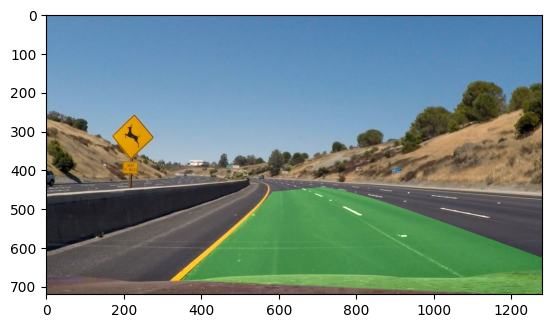

In [30]:
'''test'''
# img = mpimg.imread('../test_images/straight_lines1.jpg')
# img = cv2.imread('../test_images/straight_lines2.jpg')
# img = mpimg.imread('../test_images/test1.jpg')
img = mpimg.imread('../test_images/test2.jpg')
# img = mpimg.imread('../test_images/test3.jpg')

# img = mpimg.imread('../test_images/test4.jpg')
# img = mpimg.imread('../test_images/test5.jpg')
#img = mpimg.imread('../test_images/test6.jpg')

out_img = lane_finding_pipeline(img)
plt.imshow(out_img)

In [31]:

video_output = '../challenge_video_output1.mp4'
clip1 = VideoFileClip("../challenge_video.mp4")
output_clip = clip1.fl_image(lane_finding_pipeline)
%time output_clip.write_videofile(video_output, audio = False)

Moviepy - Building video ../challenge_video_output1.mp4.
Moviepy - Writing video ../challenge_video_output1.mp4



Moviepy - Done !
Moviepy - video ready ../challenge_video_output1.mp4
CPU times: total: 2min 7s
Wall time: 50.8 s
